In [342]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
import boto3
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
%matplotlib inline

In [67]:
# Read the expected csv (the original data)

In [306]:
def load_data(csv_name):
    data = pd.read_csv(csv_name, error_bad_lines=False)
    return data

def rename_test_cols(test):
    y_test.rename(columns={'brand_id' : 'brand_id_expected',
                            'super_brand_id' : 'super_brand_id_expected',
                            'serving_type_id' : 'serving_type_id_expected',
                            'volume_id' : 'volume_id_expected'}, inplace=True)
    
    
def rename_pred_cols(pred):
    pred.columns = ['super_brand_id_pred', 'super_brand_id_prob', 
                     'serving_type_id_pred', 'serving_type_id_prob', 
                     'volume_id_pred', 'volume_id_prob', 
                     'brand_id_pred', 'brand_id_prob', 
                     'bar_product_id', 'algo_type']

In [315]:
y_test = load_data('input_beer.csv')
rename_test_cols(y_test)
y_pred = pd.read_csv('nn_results.csv', header=None)
rename_pred_cols(y_pred)
products_revenue = load_data('products_revenue.csv')

In [318]:
print("y_test shape: ", y_test.shape)
print("y_test cols: ", y_test.columns)
print("y_pred shape: ", y_pred.shape)
print("y_pred cols: ", y_pred.columns)
print("products_revenue shape: ", products_revenue.shape)
print("products_revenue cols: ", products_revenue.columns)

('y_test shape: ', (72660, 13))
('y_test cols: ', Index([u'bar_product_id', u'brand_id_expected', u'title', u'price',
       u'category_id', u'country_id', u'pos_category_name',
       u'super_brand_id_expected', u'volume_id_expected', u'beer_type_id',
       u'serving_type_id_expected', u'unique_id', u'train'],
      dtype='object'))
('y_pred shape: ', (30000, 10))
('y_pred cols: ', Index([u'super_brand_id_pred', u'super_brand_id_prob', u'serving_type_id_pred',
       u'serving_type_id_prob', u'volume_id_pred', u'volume_id_prob',
       u'brand_id_pred', u'brand_id_prob', u'bar_product_id', u'algo_type'],
      dtype='object'))
('products_revenue shape: ', (70251, 2))
('products_revenue cols: ', Index([u'bar_product_id', u'revenue'], dtype='object'))


In [314]:
# Show items with no prediction!!!! Error....
y_pred[y_pred['brand_id_pred'].isnull()]

Empty DataFrame
Columns: [super_brand_id_pred, super_brand_id_prob, serving_type_id_pred, serving_type_id_prob, volume_id_pred, volume_id_prob, brand_id_pred, brand_id_prob, bar_product_id, algo_type]
Index: []

In [323]:
test_pred_df = y_test.merge(y_pred, on='bar_product_id')
main_df = test_pred_df.merge(products_revenue, on='bar_product_id')
print("test_pred_df: ", test_pred_df.shape, "main_df: ", main_df.shape)

('test_pred_df: ', (30000, 22), 'main_df: ', (29019, 23))


In [324]:
main_df.head()

bar_product_id  brand_id_expected                title  price  category_id  \
0           14207                291      C. BIERE ROUSSE   7.00            1   
1          447627                128  SCEAU DE CORONA (5)  21.75            1   
2          584092                128               CORONA   8.00            1   
3          636786               1511     BARTNDR.CHOIC.4z   1.79            1   
4          652281                 26          GUINNESS.XL  10.66            1   

  country_id    pos_category_name  super_brand_id_expected  \
0     Canada  BIERE WEST SHEFFORD                        0   
1     Canada               bieres                       58   
2     Canada      bieresimportees                       58   
3     Canada                draft                        0   
4     Canada                draft                        1   

   volume_id_expected  beer_type_id   ...     super_brand_id_pred  \
0               0.591           9.0   ...                       0   
1               1.650           1.0   ...                      58   
2               0.355           1.0   ...                      58   
3               0.118           8.0   ...                       0   
4               0.591           3.0   ...                       1   

  super_brand_id_prob  serving_type_id_pred  serving_type_id_prob  \
0                0.89                     2                  0.49   
1                1.00                     1                  0.98   
2                1.00                     1                  0.98   
3                1.00                     2                  0.99   
4                1.00                     2                  1.00   

   volume_id_pred  volume_id_prob  brand_id_pred  brand_id_prob  algo_type  \
0           0.591            0.26            214           0.24         NN   
1           1.650            0.50            128           1.00         NN   
2           0.355            0.88            128           1.00         NN   
3           0.118            0.98           1511           1.00         NN   
4           0.591            0.95             26           1.00         NN   

   revenue  
0   133.00  
1  1696.50  
2   536.00  
3   278.71  
4   280.22  

[5 rows x 23 columns]

In [42]:
#y_pred['category_id_prob'] = y_pred['category_id_prob'].apply(lambda prob: round(prob, 2))

In [219]:
total = y_pred.shape[0]
for column in y_pred.columns:
    if column.endswith('_prob'):
        above_thesh = y_pred[y_pred[column] > 0.9].shape[0]
        print('Items above theshold for column', column, 'are: ', above_thesh, 'out of', total, above_thesh/total)

('Items above theshold for column', 'super_brand_id_prob', 'are: ', 28411, 'out of', 30000, 0)
('Items above theshold for column', 'serving_type_id_prob', 'are: ', 20631, 'out of', 30000, 0)
('Items above theshold for column', 'volume_id_prob', 'are: ', 11799, 'out of', 30000, 0)
('Items above theshold for column', 'brand_id_prob', 'are: ', 22290, 'out of', 30000, 0)


In [220]:
y_pred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 10 columns):
super_brand_id_actual     30000 non-null int64
super_brand_id_prob       30000 non-null float64
serving_type_id_actual    30000 non-null int64
serving_type_id_prob      30000 non-null float64
volume_id_actual          30000 non-null float64
volume_id_prob            30000 non-null float64
brand_id_actual           30000 non-null int64
brand_id_prob             30000 non-null float64
bar_product_id            30000 non-null int64
algo_type                 30000 non-null object
dtypes: float64(5), int64(4), object(1)
memory usage: 2.3+ MB


In [221]:
#y_pred['category_id_actual'] = y_pred['category_id_actual'].astype('int')

## Choose the column to show results

In [89]:
#chosen_column = 'serving_type_id'
#chosen_column = 'brand_id'
#chosen_column = 'super_brand_id'
chosen_column = 'volume_id'

In [90]:
test_pred_df['volume_id_actual'] = test_pred_df['volume_id_actual'].astype(str)
test_pred_df['volume_id_expected'] = test_pred_df['volume_id_expected'].astype(str)

In [91]:
test_pred_df[chosen_column + '_expected'].nunique()

308

In [92]:
test_pred_df[chosen_column + '_actual'].nunique()

266

In [93]:
test_pred_df[['bar_product_id', 'title', chosen_column + '_expected', 
           chosen_column + '_actual', chosen_column + '_prob']].head(10)

bar_product_id                title   volume_id_expected  \
0           14207      C. BIERE ROUSSE                0.591   
1          447627  SCEAU DE CORONA (5)                 1.65   
2          584092               CORONA                0.355   
3          636786     BARTNDR.CHOIC.4z  0.11800000000000001   
4          652281          GUINNESS.XL                0.591   
5          652737         GOOSE.IPA.XL                0.591   
6          663058     ROLL.ROCK.DRF.Mg                0.355   
7          663077       STM WHISTLE.XL                0.591   
8          669298         BEAUS.ALE.Jg                1.538   
9          675730     BARK.SQRL.DRF.Jg                1.538   

      volume_id_actual  volume_id_prob  
0                0.591            0.26  
1                 1.65            0.50  
2                0.355            0.88  
3  0.11800000000000001            0.98  
4                0.591            0.95  
5                0.591            0.98  
6                0.355            0.99  
7                0.591            0.99  
8                1.538            1.00  
9                1.538            1.00

## Find the optimal threshold

In [325]:
main_df.columns

Index([u'bar_product_id', u'brand_id_expected', u'title', u'price',
       u'category_id', u'country_id', u'pos_category_name',
       u'super_brand_id_expected', u'volume_id_expected', u'beer_type_id',
       u'serving_type_id_expected', u'unique_id', u'train',
       u'super_brand_id_pred', u'super_brand_id_prob', u'serving_type_id_pred',
       u'serving_type_id_prob', u'volume_id_pred', u'volume_id_prob',
       u'brand_id_pred', u'brand_id_prob', u'algo_type', u'revenue'],
      dtype='object')

In [420]:
report_df = main_df
# start = 0.5
threshold_range = np.arange(0.5, 1, .01)
threshold_list = []
accuracy_list = []
matching_size_list = []
revenue_size_list = []
total_obs = report_df.shape[0]
total_revenue = report_df.revenue.sum()
final_dict = {}

print(threshold_range)
for t in threshold_range:
    
    threshold = t
    print(threshold)
    
    above_threshold_df = report_df[(report_df['brand_id' + '_prob'] > threshold) &\
                        (report_df['volume_id' + '_prob'] > threshold) &\
                        (report_df['serving_type_id' + '_prob'] > threshold)]
    
    above_threshold_df['accuracy'] = np.where((above_threshold_df['brand_id_expected'] == above_threshold_df['brand_id_pred']) &\
                                              (above_threshold_df['volume_id_expected'] == above_threshold_df['volume_id_pred'])&\
                                              (above_threshold_df['serving_type_id_expected'] == above_threshold_df['serving_type_id_pred']), 1, 0)
    
    fully_predicted = float(above_threshold_df[above_threshold_df['accuracy'] == 1].shape[0])
    above_threshold_count = float(above_threshold_df.shape[0])
    above_threshold_revenue = float(above_threshold_df.revenue.sum())

    accuracy = fully_predicted/total_obs
    matching_size = above_threshold_count/total_obs
    revenue_size = above_threshold_revenue/total_revenue
    
    threshold_list.append(threshold)
    accuracy_list.append(accuracy)
    matching_size_list.append(matching_size)
    revenue_size_list.append(revenue_size)
    
    key = threshold
    value = {'accuracy':accuracy, 'matching_size': matching_size, 'revenue_size':revenue_size}   
    final_dict[threshold] = value
    

[0.5  0.51 0.52 0.53 0.54 0.55 0.56 0.57 0.58 0.59 0.6  0.61 0.62 0.63
 0.64 0.65 0.66 0.67 0.68 0.69 0.7  0.71 0.72 0.73 0.74 0.75 0.76 0.77
 0.78 0.79 0.8  0.81 0.82 0.83 0.84 0.85 0.86 0.87 0.88 0.89 0.9  0.91
 0.92 0.93 0.94 0.95 0.96 0.97 0.98 0.99]
0.5
0.51
0.52
0.53
0.54
0.55
0.56
0.5700000000000001
0.5800000000000001
0.5900000000000001
0.6000000000000001
0.6100000000000001
0.6200000000000001
0.6300000000000001
0.6400000000000001
0.6500000000000001
0.6600000000000001
0.6700000000000002
0.6800000000000002
0.6900000000000002
0.7000000000000002
0.7100000000000002
0.7200000000000002
0.7300000000000002
0.7400000000000002
0.7500000000000002
0.7600000000000002
0.7700000000000002
0.7800000000000002
0.7900000000000003
0.8000000000000003
0.8100000000000003
0.8200000000000003
0.8300000000000003
0.8400000000000003
0.8500000000000003
0.8600000000000003
0.8700000000000003
0.8800000000000003
0.8900000000000003
0.9000000000000004
0.9100000000000004
0.9200000000000004
0.9300000000000004
0.940000

In [ ]:
col = 'brand_id'

In [420]:
report_df = main_df
# start = 0.5
threshold_range = np.arange(0.5, 1, .01)
threshold_list = []
accuracy_list = []
matching_size_list = []
revenue_size_list = []
total_obs = report_df.shape[0]
total_revenue = report_df.revenue.sum()
final_dict = {}

for t in threshold_range:
    
    threshold = t
    print(threshold)
    
    above_threshold_df = report_df[(report_df[col + '_prob'] > threshold)]
    
    accuracy = accuracy_score
    above_threshold_count = float(above_threshold_df.shape[0])
    above_threshold_revenue = float(above_threshold_df.revenue.sum())

    accuracy = fully_predicted/total_obs
    matching_size = above_threshold_count/total_obs
    revenue_size = above_threshold_revenue/total_revenue
    
    threshold_list.append(threshold)
    accuracy_list.append(accuracy)
    matching_size_list.append(matching_size)
    revenue_size_list.append(revenue_size)
    
    key = threshold
    value = {'accuracy':accuracy, 'matching_size': matching_size, 'revenue_size':revenue_size}   
    final_dict[threshold] = value
    

[0.5  0.51 0.52 0.53 0.54 0.55 0.56 0.57 0.58 0.59 0.6  0.61 0.62 0.63
 0.64 0.65 0.66 0.67 0.68 0.69 0.7  0.71 0.72 0.73 0.74 0.75 0.76 0.77
 0.78 0.79 0.8  0.81 0.82 0.83 0.84 0.85 0.86 0.87 0.88 0.89 0.9  0.91
 0.92 0.93 0.94 0.95 0.96 0.97 0.98 0.99]
0.5
0.51
0.52
0.53
0.54
0.55
0.56
0.5700000000000001
0.5800000000000001
0.5900000000000001
0.6000000000000001
0.6100000000000001
0.6200000000000001
0.6300000000000001
0.6400000000000001
0.6500000000000001
0.6600000000000001
0.6700000000000002
0.6800000000000002
0.6900000000000002
0.7000000000000002
0.7100000000000002
0.7200000000000002
0.7300000000000002
0.7400000000000002
0.7500000000000002
0.7600000000000002
0.7700000000000002
0.7800000000000002
0.7900000000000003
0.8000000000000003
0.8100000000000003
0.8200000000000003
0.8300000000000003
0.8400000000000003
0.8500000000000003
0.8600000000000003
0.8700000000000003
0.8800000000000003
0.8900000000000003
0.9000000000000004
0.9100000000000004
0.9200000000000004
0.9300000000000004
0.940000

In [436]:
# final_dict.keys()

print(final_dict.get(0.8500000000000003))
# final_dict

{'revenue_size': 0.4365172116996623, 'matching_size': 0.3992211999035115, 'accuracy': 0.374720011027258}


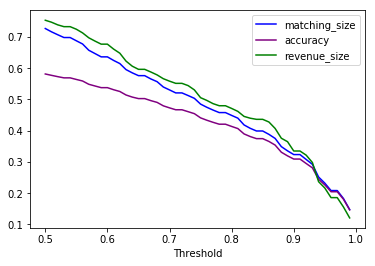

In [426]:
plt.plot(threshold_list, matching_size_list, color='blue', label='matching_size')
plt.plot(threshold_list, accuracy_list, color='purple', label='accuracy')
plt.plot(threshold_list, revenue_size_list, color='green', label='revenue_size')
plt.legend()
plt.xlabel('Threshold')
# plt.ylabel('Matching Size')
plt.show()

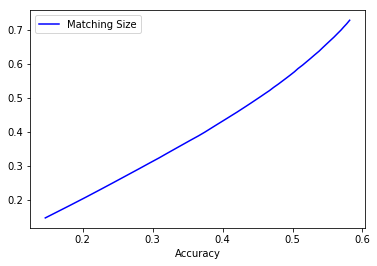

In [429]:
plt.plot(accuracy_list, matching_size_list, color='blue', label='Matching Size')
# plt.plot(threshold_list, accuracy_list, color='purple', label='accuracy')
# plt.plot(threshold_list, revenue_size_list, color='green', label='revenue_size')
plt.legend()
plt.xlabel('Accuracy')
# plt.ylabel('Matching Size')
plt.show()

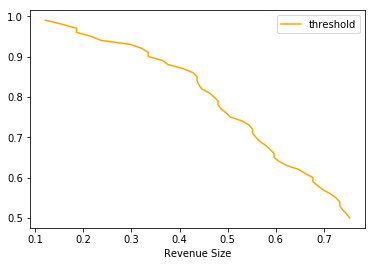

In [431]:
plt.plot(revenue_size_list, threshold_list, color='orange', label='threshold')
# plt.plot(threshold_list, accuracy_list, color='purple', label='accuracy')
# plt.plot(threshold_list, revenue_size_list, color='green', label='revenue_size')
plt.legend()
plt.xlabel('Revenue Size')
# plt.ylabel('Matching Size')
plt.show()

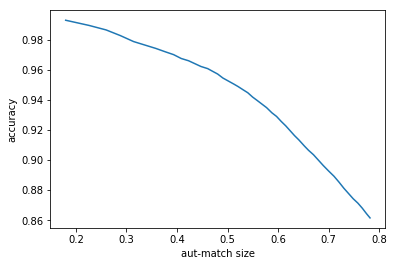

In [122]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(matching_size_list, accuracy_list)
plt.xlabel('aut-match size')
plt.ylabel('accuracy')
plt.show()

In [123]:
# Choose your theshold

In [126]:
def classification_report_to_df(report):
    report_data = []
    lines = report.split('\n')
    for line in lines[2:-3]:
        row = {}
        row_data = line.split('      ')
        row['class'] = row_data[1].strip()
        row['precision'] = float(row_data[1].strip())
        row['recall'] = float(row_data[2].strip())
        row['f1_score'] = float(row_data[3].strip())
        row['support'] = float(row_data[4].strip())
        report_data.append(row)
    dataframe = pd.DataFrame.from_dict(report_data)
    return dataframe

In [127]:
top_df = test_pred_df[test_pred_df[chosen_column + '_prob'] > 0.7]
print(top_df.shape[0], 'out of', test_pred_df.shape[0], 'with coverage', top_df.shape[0]/test_pred_df.shape[0])
y_true = top_df[chosen_column + '_expected']
y_pred = top_df[chosen_column + '_actual']
print(accuracy_score(y_true, y_pred))

print(classification_report(y_true, y_pred))

18175 out of 29999 with coverage 0.6058535284509484
0.9257221458046767
                      precision    recall  f1-score   support

                 0.0       0.00      0.00      0.00        22
                0.02       0.90      1.00      0.95        26
0.028999999999999998       1.00      0.67      0.80         3
                0.03       0.82      0.82      0.82        11
 0.11800000000000001       0.98      0.99      0.99       113
               0.142       0.90      0.75      0.82        12
               0.147       0.00      0.00      0.00         1
 0.14800000000000002       0.75      1.00      0.86        18
                0.15       0.97      1.00      0.98        30
 0.16399999999999998       0.00      0.00      0.00         2
               0.177       0.77      1.00      0.87        24
                0.18       0.00      0.00      0.00         1
               0.188       0.00      0.00      0.00         2
 0.18899999999999997       0.92      1.00      0.96        7

/Users/israelsofer/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/israelsofer/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [128]:
report = classification_report(y_true, y_pred)
report_df = classification_report_to_df(report)
report_df.head()

/Users/israelsofer/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/israelsofer/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


ValueError: could not convert string to float: 

In [129]:
report_df[(report_df.f1_score < 0.9) & (report_df.support > 5)]

AttributeError: 'DataFrame' object has no attribute 'f1_score'

# Write code to check the mistakes for the threshold chosen

In [67]:
# Mistakes with Category X
X = 3
test_pred_df[(test_pred_df.category_id_prob > 0.9) & ((test_pred_df.category_id_actual != X) & 
                                                (test_pred_df.category_id_expected == X))]

bar_product_id                                              title  \
84             1647678                                      Rib Eye 500gr   
366            5044834                                250ml Fly Zeb - Red   
517            6582064                                    PRIVATEER AMBER   
742             979734                                       VOIR SERVEUR   
1204           6001788                                    VIRGIN LONG ISL   
1244           6466279  Louis Bouillot, Brut Rosé, Crémant de Bourgogn...   
1528           1874020                                          STELLA.Mg   
1968           6207617                                      Lillet Blonde   
2765           7221716                                 happy black velvet   
3279           5105072                                   Hot Drink Refill   
3794           3017899                BrookVale Union Ginger Beer can 6pk   
3955           4194150                                                7UP   
4157           6200938                                          Negra Btl   
4164           6285421                                  Funaguchi (200ml)   
4498           2679564                                          open misc   
4765           5157748                                    Jif lemon juice   
4854           6081516                            DO NOT MAKE Archie Rose   
6196           4974858                                   J20 Apple & Rasp   
6723           3531482                                             MIMOSA   
6961           5275096                     CK 100ml Sour Worms On Ice 6mg   
7664           5225542                                    LG - TOM.B.PARM   
8339           4970415                                    Lemonade (half)   
8428           5671091                                 175ml Absurd Blanc   
8437           5791478                                      Post Mix Pint   
9269           6815955                               Gls Cow Bombie Chard   
9865           5289416                             Maxi Everyday Brew Tea   
10497          4368715                                      Macchiato Dbl   
10640          5920336                                       2 x coke can   
10996          2981366                                    Pitcher Mojitto   
11800          3122767                               Polarised Sunglasses   
...                ...                                                ...   
137887         7104929                                     Spanish Coffee   
137908         7309050                                     Shirley Temple   
138375         4324203                                         PS Gl Jeio   
138854         1733292                                   REK. SPICED PLUM   
139149         5096746                                 Coffee Delight x 1   
139495         1244042                                       BELAIRE ROSE   
139568         2292162                                        1L Red Sang   
139582         2685104                                     KIDS ORANGEADE   
139730         4075624                             Henry Weinhard - Grape   
140390         3779652                       Lazy Magnolia Southern Pecan   
140516         4778390                                        Spirit Misc   
140659         6168443                      Virgin Blood Orange Margarita   
140882          451786                                                KIR   
140944         1488809                                           Lg Pepsi   
140948         1530956                              Campo Tempranillo 6oz   
141268         5289552                             Classroom Bitter 1/2pt   
141424         7128298                                               Judy   
141449         7497139                                    Miller N Mezcal   
141626         1563780                                       Dinner Grill   
141661         1955321                                             DIVERS   
1423